# 频繁模式与关联规则挖掘

## 1.对数据集进行处理，转换成适合关联规则挖掘的形式

In [2]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('DA_input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


初步分析数据集，推测可能存在的频繁模式和关联规则：

1.葡萄酒产自的国家、酿酒的葡萄品种与酒庄之间——某些特定产地的葡萄酒可能有自己固定的用来酿酒的葡萄品种；

2.品酒师、葡萄酒品种与打分之间——品酒师们可能钟爱某几种特定的葡萄酒品种，并且打分时有某种规律。


In [14]:
#筛选出国家、葡萄品种、酒庄信息，构成事务集
transactions_1 = []
for index, row in df.iterrows():
    transactions_1 += [(row['country'], row['variety'], row['winery'])]
transactions_1[:20]

[('Italy', 'White Blend', 'Nicosia'),
 ('Portugal', 'Portuguese Red', 'Quinta dos Avidagos'),
 ('US', 'Pinot Gris', 'Rainstorm'),
 ('US', 'Riesling', 'St. Julian'),
 ('US', 'Pinot Noir', 'Sweet Cheeks'),
 ('Spain', 'Tempranillo-Merlot', 'Tandem'),
 ('Italy', 'Frappato', 'Terre di Giurfo'),
 ('France', 'Gewürztraminer', 'Trimbach'),
 ('Germany', 'Gewürztraminer', 'Heinz Eifel'),
 ('France', 'Pinot Gris', 'Jean-Baptiste Adam'),
 ('US', 'Cabernet Sauvignon', 'Kirkland Signature'),
 ('France', 'Gewürztraminer', 'Leon Beyer'),
 ('US', 'Cabernet Sauvignon', 'Louis M. Martini'),
 ('Italy', 'Nerello Mascalese', 'Masseria Setteporte'),
 ('US', 'Chardonnay', 'Mirassou'),
 ('Germany', 'Riesling', 'Richard Böcking'),
 ('Argentina', 'Malbec', 'Felix Lavaque'),
 ('Argentina', 'Malbec', 'Gaucho Andino'),
 ('Spain', 'Tempranillo Blend', 'Pradorey'),
 ('US', 'Meritage', 'Quiévremont')]

In [15]:
#筛选出品酒师姓名、评分、葡萄品种、酒庄信息，构成事务集
transactions_2 = []
for index, row in df.iterrows():
    transactions_2 += [(row['taster_name'], row['points'], row['variety'], row['winery'])]
transactions_2[:20]

[('Kerin O’Keefe', 87, 'White Blend', 'Nicosia'),
 ('Roger Voss', 87, 'Portuguese Red', 'Quinta dos Avidagos'),
 ('Paul Gregutt', 87, 'Pinot Gris', 'Rainstorm'),
 ('Alexander Peartree', 87, 'Riesling', 'St. Julian'),
 ('Paul Gregutt', 87, 'Pinot Noir', 'Sweet Cheeks'),
 ('Michael Schachner', 87, 'Tempranillo-Merlot', 'Tandem'),
 ('Kerin O’Keefe', 87, 'Frappato', 'Terre di Giurfo'),
 ('Roger Voss', 87, 'Gewürztraminer', 'Trimbach'),
 ('Anna Lee C. Iijima', 87, 'Gewürztraminer', 'Heinz Eifel'),
 ('Roger Voss', 87, 'Pinot Gris', 'Jean-Baptiste Adam'),
 ('Virginie Boone', 87, 'Cabernet Sauvignon', 'Kirkland Signature'),
 ('Roger Voss', 87, 'Gewürztraminer', 'Leon Beyer'),
 ('Virginie Boone', 87, 'Cabernet Sauvignon', 'Louis M. Martini'),
 ('Kerin O’Keefe', 87, 'Nerello Mascalese', 'Masseria Setteporte'),
 ('Matt Kettmann', 87, 'Chardonnay', 'Mirassou'),
 ('Anna Lee C. Iijima', 87, 'Riesling', 'Richard Böcking'),
 ('Michael Schachner', 87, 'Malbec', 'Felix Lavaque'),
 ('Michael Schachner', 

## 2.找出频繁模式

使用Apriori算法

In [4]:
from collections import defaultdict
import itertools


def apriori(transactions, support=0.1, confidence=0.8, lift=1, minlen=2, maxlen=2):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)

    for tranidx, tran in enumerate(transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)

    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])

    tran_count = float(len(transactions))
    # print('Extracting rules in {} transactions...'.format(int(tran_count)))

    valid_items = set(item
        for item, tranidxs in item_2_tranidxs.items()
            if (len(tranidxs) / tran_count >= support))

    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []

    if minlen == 1:
        freqsets.extend(pivot_itemsets)

    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []

        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= support:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs

        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)

        pivot_itemsets = new_itemsets

    # print('{} frequent patterns found'.format(len(freqsets)))

    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            support_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if support_rhs >= support and support_rhs > confidence and lift_rhs > lift:
                    yield (lhs, rhs, support_rhs, support_rhs, lift_rhs)
            else:
                confidence_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                    / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = confidence_lhs_rhs / support_rhs

                if confidence_lhs_rhs >= confidence and lift_lhs_rhs > lift:
                    support_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, support_lhs_rhs, confidence_lhs_rhs, lift_lhs_rhs)

设置频繁项集支持度、置信度、lift阈值：（support>0.03, confidence>0.1, lift>1）

In [16]:
#第一类：country-variety-winery中的频繁模式
rules_1 = apriori(transactions_1, support=0.03, confidence=0.1, lift=1)
rules1_sorted = sorted(rules_1, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

for r in rules1_sorted:
    print(r)

(frozenset({'Bordeaux-style Red Blend'}), frozenset({'France'}), 0.03635426364342815, 0.6832971800433839, 4.019771773295553)
(frozenset({'France'}), frozenset({'Bordeaux-style Red Blend'}), 0.03635426364342815, 0.2138686461775223, 4.019771773295553)
(frozenset({'Cabernet Sauvignon'}), frozenset({'US'}), 0.05628178593686284, 0.7722761824324325, 1.841580575864628)
(frozenset({'US'}), frozenset({'Cabernet Sauvignon'}), 0.05628178593686284, 0.13421033318655512, 1.841580575864628)
(frozenset({'Pinot Noir'}), frozenset({'US'}), 0.07605542774926714, 0.7448010849909584, 1.7760630745882846)
(frozenset({'US'}), frozenset({'Pinot Noir'}), 0.07605542774926714, 0.18136283575517392, 1.7760630745882844)
(frozenset({'Chardonnay'}), frozenset({'US'}), 0.052327057574381976, 0.5786607674636263, 1.3798825518863749)
(frozenset({'US'}), frozenset({'Chardonnay'}), 0.052327057574381976, 0.12477983267283135, 1.3798825518863749)


In [17]:
#第二类：taster-points-variety-winery中的频繁模式
rules_2 = apriori(transactions_2, support=0.03, confidence=0.1, lift=1)
rules2_sorted = sorted(rules_2, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

for r in rules2_sorted:
    print(r)

(frozenset({'Bordeaux-style Red Blend'}), frozenset({'Roger Voss'}), 0.03623885328265536, 0.6811279826464208, 3.4697375963211554)
(frozenset({'Roger Voss'}), frozenset({'Bordeaux-style Red Blend'}), 0.03623885328265536, 0.18460453084581013, 3.469737596321155)
(frozenset({87}), frozenset({nan}), 0.03125312569727093, 0.23988661194117994, 1.1880164167279035)
(frozenset({nan}), frozenset({87}), 0.03125312569727093, 0.1547782350251486, 1.1880164167279035)


## 3.导出关联规则，计算其支持度和置信度

In [22]:
import csv 

with open('result1.csv', 'wt') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['rule', 'sup', 'conf', 'lift'])
    for r in rules1_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])

pd.read_csv('result1.csv')

,rule,sup,conf,lift
0,Bordeaux-style Red Blend => France,0.036354,0.683297,4.019772
1,France => Bordeaux-style Red Blend,0.036354,0.213869,4.019772
2,Cabernet Sauvignon => US,0.056282,0.772276,1.841581
3,US => Cabernet Sauvignon,0.056282,0.134210,1.841581
4,Pinot Noir => US,0.076055,0.744801,1.776063
5,US => Pinot Noir,0.076055,0.181363,1.776063
6,Chardonnay => US,0.052327,0.578661,1.379883
7,US => Chardonnay,0.052327,0.124780,1.379883


In [23]:
import csv 

with open('result2.csv', 'wt') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['rule', 'sup', 'conf', 'lift'])
    for r in rules2_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])

pd.read_csv('result2.csv')

,rule,sup,conf,lift
0,Bordeaux-style Red Blend => Roger Voss,0.036239,0.681128,3.469738
1,Roger Voss => Bordeaux-style Red Blend,0.036239,0.184605,3.469738
2,87 => nan,0.031253,0.239887,1.188016
3,nan => 87,0.031253,0.154778,1.188016


## 4.对规则进行评价，使用Lift、Kulc指标

前边已经计算了Lift，这里再补充Kulc指标。

In [20]:
res = []
for r in rules1_sorted:
    conf1 = r[3]
    for r2 in rules1_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)

res

[0.4485829131104531,
 0.4485829131104531,
 0.4532432578094938,
 0.4532432578094938,
 0.46308196037306615,
 0.46308196037306615,
 0.3517203000682288,
 0.3517203000682288]

In [21]:
res = []
for r in rules2_sorted:
    conf1 = r[3]
    for r2 in rules2_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)

res

[0.43286625674611545,
 0.43286625674611545,
 0.19733242348316427,
 0.19733242348316427]

## 5.对挖掘结果进行分析

In [24]:
pd.read_csv('result1.csv')

,rule,sup,conf,lift
0,Bordeaux-style Red Blend => France,0.036354,0.683297,4.019772
1,France => Bordeaux-style Red Blend,0.036354,0.213869,4.019772
2,Cabernet Sauvignon => US,0.056282,0.772276,1.841581
3,US => Cabernet Sauvignon,0.056282,0.134210,1.841581
4,Pinot Noir => US,0.076055,0.744801,1.776063
5,US => Pinot Noir,0.076055,0.181363,1.776063
6,Chardonnay => US,0.052327,0.578661,1.379883
7,US => Chardonnay,0.052327,0.124780,1.379883


分析：

规则中显示，葡萄酒品种与葡萄酒产自的国家之间的确有较强的关联关系。可以结合现实信息加以佐证。

例如，Bordeaux-style Red Blend 波尔多红酒，有“法国葡萄酒皇后”的美称，是世界公认最大的葡萄酒产地。它坐落在美丽的法国。

再如，Cabernet Sauvignon 赤霞珠，是一种用于酿造葡萄酒的红葡萄品种，是世界上最流行的红葡萄品种，适应性较好，在全球多地有种植。而在美国加州，赤霞珠是最为广泛种植的红葡萄品种。

Pinot Noir 黑皮诺葡萄，是在世界上最受欢迎的葡萄之一，美国加州的黑比诺以果味丰富和浓重辛香为特点。

【源自百度百科】


In [28]:
pd.read_csv('result2.csv')

,rule,sup,conf,lift
0,Bordeaux-style Red Blend => Roger Voss,0.036239,0.681128,3.469738
1,Roger Voss => Bordeaux-style Red Blend,0.036239,0.184605,3.469738
2,87 => nan,0.031253,0.239887,1.188016
3,nan => 87,0.031253,0.154778,1.188016


分析：

规则中显示，品酒师Roger Voss与波尔多红酒之间有较强的关联。经过了解得知，罗杰·沃斯是知名杂志《葡萄酒爱好者》（Wine Enthusiast）欧洲版的编辑，专注于品鉴波尔多、勃艮第、香槟（Champagne）、卢瓦尔河谷、法国西南部和葡萄牙产区的酒款。在葡萄酒评分方面，罗杰·沃斯采用100分制的评分体系。

【红酒世界网】

很多品酒师姓名为空的记录，大都给出了87的评分。


采样加以验证：

In [27]:
df[df['variety'] == 'Bordeaux-style Red Blend'].sample(15)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
70986,US,"This half Cabernet, one quarter each Merlot an...",Sagemoor Vineyard Reserve,90,50.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Tamarack Cellars 2006 Sagemoor Vineyard Reserv...,Bordeaux-style Red Blend,Tamarack Cellars
7010,France,"Layered with toasty wood, this rich wine deliv...",Cuvée Prevenche,89,14.0,Bordeaux,Castillon Côtes de Bordeaux,NaN,Roger Voss,@vossroger,Château Terrasson 2012 Cuvée Prevenche (Casti...,Bordeaux-style Red Blend,Château Terrasson
47805,France,The wine is dense with some fine concentrated ...,Tradition,88,15.0,Bordeaux,Bordeaux Supérieur,NaN,Roger Voss,@vossroger,Château Lauduc 2014 Tradition (Bordeaux Supér...,Bordeaux-style Red Blend,Château Lauduc
78382,South Africa,Brims with dark fruit notes of mulled boysenbe...,Faithful Hound,90,22.0,Stellenbosch,NaN,NaN,Lauren Buzzeo,@laurbuzz,Mulderbosch 2008 Faithful Hound Red (Stellenbo...,Bordeaux-style Red Blend,Mulderbosch
4768,France,"A firm, dense wine, it currently shows plenty ...",NaN,90,NaN,Bordeaux,Saint-Estèphe,NaN,Roger Voss,@vossroger,Château Saint-Estèphe 2011 Saint-Estèphe,Bordeaux-style Red Blend,Château Saint-Estèphe
43464,US,"This wine is a blend of Cabernet Sauvignon, Me...",Proprietary,90,50.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Swiftwater Cellars 2014 Proprietary Red (Colum...,Bordeaux-style Red Blend,Swiftwater Cellars
121274,US,This Bordeaux-style blend has pretty aromas of...,First Bridge,86,36.0,Virginia,Virginia,NaN,Carrie Dykes,NaN,Slater Run 2014 First Bridge Red (Virginia),Bordeaux-style Red Blend,Slater Run
37489,France,"Oak influence shows strongly on this wine, giv...",NaN,86,40.0,Bordeaux,Saint-Estèphe,NaN,Roger Voss,@vossroger,Château de Côme 2011 Saint-Estèphe,Bordeaux-style Red Blend,Château de Côme
1800,France,"Solid and powerful, it has a great mix of very...",Cuvée Reine,91,29.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château de Roquebrune 2010 Cuvée Reine (Lalan...,Bordeaux-style Red Blend,Château de Roquebrune
19653,France,While this wine shows some of the softness and...,NaN,83,24.0,Bordeaux,Graves,NaN,Roger Voss,@vossroger,Château Toumilon 2003 Graves,Bordeaux-style Red Blend,Château Toumilon


In [33]:
df[df['variety'] == 'Cabernet Sauvignon'].sample(15)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
52552,Chile,"Leafy, green, minty aromas blend with riper no...",Armador,87,13.0,Maipo Valley,NaN,NaN,Michael Schachner,@wineschach,Odfjell 2011 Armador Cabernet Sauvignon (Maipo...,Cabernet Sauvignon,Odfjell
105978,US,This manages to combine instant drinkability w...,Reserve,88,30.0,California,Napa Valley,Napa,NaN,NaN,Martin Ray 2010 Reserve Cabernet Sauvignon (Na...,Cabernet Sauvignon,Martin Ray
82046,US,Juicy cranberry and cassis characterize this C...,NaN,89,50.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Clos Pegase 2010 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Clos Pegase
63960,US,"This is a simple, soft, easy to drink Cabernet...",Four Bears,84,16.0,California,Paso Robles,Central Coast,NaN,NaN,Sean Minor 2010 Four Bears Cabernet Sauvignon ...,Cabernet Sauvignon,Sean Minor
206,US,This is an extraordiary deal for a solidly bui...,NaN,90,25.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Courtney Benham 2014 Cabernet Sauvignon (Napa ...,Cabernet Sauvignon,Courtney Benham
101046,US,"A big Cabernet, showing the dramatic mouthfeel...",Parady Vineyard,89,59.0,California,Napa Valley,Napa,NaN,NaN,Kasuari 2010 Parady Vineyard Cabernet Sauvigno...,Cabernet Sauvignon,Kasuari
118455,US,Winemaker Nick Goldschmidt is behind this wine...,Hillside Reserve,89,75.0,California,Knights Valley,Sonoma,Virginie Boone,@vboone,Ehret 2010 Hillside Reserve Cabernet Sauvignon...,Cabernet Sauvignon,Ehret
26619,US,Made from 100% Cabernet Sauvignon and aged in ...,NaN,89,48.0,California,Napa Valley,Napa,NaN,NaN,C. Beck 2008 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,C. Beck
81069,Australia,"Consistent with the Penfolds style, this is a ...",Bin 407,89,31.0,South Australia,South Australia,NaN,Joe Czerwinski,@JoeCz,Penfolds 2005 Bin 407 Cabernet Sauvignon (Sout...,Cabernet Sauvignon,Penfolds
89639,Chile,"What deep, supple flavors on this soft, delici...",NaN,87,8.0,Central Valley,NaN,NaN,NaN,NaN,Caliterra 1999 Cabernet Sauvignon (Central Val...,Cabernet Sauvignon,Caliterra


## 6.可视化展示

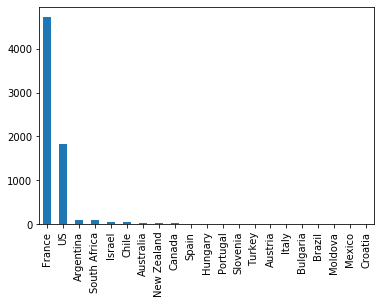

In [8]:
df[df['variety'] == 'Bordeaux-style Red Blend']['country'].value_counts().plot(kind='bar')

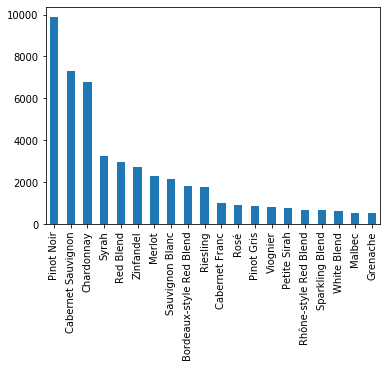

In [35]:
df[df['country'] == 'US']['variety'].value_counts().head(20).plot(kind='bar')

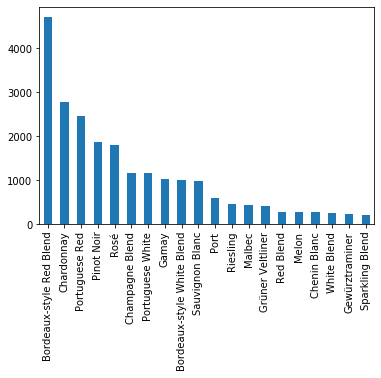

In [37]:
df[df['taster_name'] == 'Roger Voss']['variety'].value_counts().head(20).plot(kind='bar')